## Important notes:

surface level Ozone is reported in parts per million

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lasio
import xgboost as xgb
import scooby
import torch
import torch.nn as nn

from scipy.signal import filtfilt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader 
from torchsummary import summary


In [3]:
device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")
print(f'Device: {device}')

Cuda installed! Running on GPU!
Device: cuda


In [4]:
# Importing the main meteorological data

traindata = pd.read_csv('./Data/pr_temp_wind_2018_2022_Bos.csv', sep=',')


In [5]:
# Importing all other feature data

traindata_SO2_2018 = pd.read_csv('./Data/SO2_daily_2018.csv', sep=',')
traindata_SO2_2019 = pd.read_csv('./Data/SO2_daily_2019.csv', sep=',')
traindata_SO2_2020 = pd.read_csv('./Data/SO2_daily_2020.csv', sep=',')
traindata_SO2_2021 = pd.read_csv('./Data/SO2_daily_2021.csv', sep=',')

traindata_CO_2018 = pd.read_csv('./Data/CO_daily_2018.csv', sep=',')
traindata_CO_2019 = pd.read_csv('./Data/CO_daily_2019.csv', sep=',')
traindata_CO_2020 = pd.read_csv('./Data/CO_daily_2020.csv', sep=',')
traindata_CO_2021 = pd.read_csv('./Data/CO_daily_2021.csv', sep=',')

traindata_NO2_2018 = pd.read_csv('./Data/NO2_daily_2018.csv', sep=',')
traindata_NO2_2019 = pd.read_csv('./Data/NO2_daily_2019.csv', sep=',')
traindata_NO2_2020 = pd.read_csv('./Data/NO2_daily_2020.csv', sep=',')
traindata_NO2_2021 = pd.read_csv('./Data/NO2_daily_2021.csv', sep=',')

/tmp/ipykernel_268/3207368089.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2018 = pd.read_csv('./Data/SO2_daily_2018.csv', sep=',')
/tmp/ipykernel_268/3207368089.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2019 = pd.read_csv('./Data/SO2_daily_2019.csv', sep=',')
/tmp/ipykernel_268/3207368089.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2020 = pd.read_csv('./Data/SO2_daily_2020.csv', sep=',')
/tmp/ipykernel_268/3207368089.py:6: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_SO2_2021 = pd.read_csv('./Data/SO2_daily_2021.csv', sep=',')
/tmp/ipykernel_268/3207368089.py:8: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  traindata_CO_2018 = p

In [6]:
traindata = traindata.dropna()

In [7]:
traindata

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/1/2018,7.3,0.0,-14.7,-10.5,-17.7
1,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/2/2018,5.7,0.0,-12.3,-7.1,-15.5
2,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/3/2018,4.2,0.0,-6.2,-1.6,-8.8
3,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/4/2018,10.1,34.3,-3.6,-1.0,-5.5
4,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,1/5/2018,11.1,0.0,-7.8,-4.3,-14.3
...,...,...,...,...,...,...,...,...,...,...,...
1821,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/27/2022,4.5,0.0,-0.7,2.2,-2.1
1822,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/28/2022,3.8,0.0,0.2,6.1,-4.3
1823,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/29/2022,3.4,0.0,4.9,12.2,0.0
1824,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,12/30/2022,3.9,0.0,9.1,17.2,3.9


In [8]:
# Importing target data
target_data_2021 = pd.read_csv('./Data/ozone_daily_2021.csv', sep=',')
target_data_2020 = pd.read_csv('./Data/ozone_daily_2020.csv', sep=',')
target_data_2019 = pd.read_csv('./Data/ozone_daily_2019.csv', sep=',')
target_data_2018 = pd.read_csv('./Data/ozone_daily_2018.csv', sep=',')

/tmp/ipykernel_268/2871470904.py:2: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2021 = pd.read_csv('./Data/ozone_daily_2021.csv', sep=',')
/tmp/ipykernel_268/2871470904.py:3: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2020 = pd.read_csv('./Data/ozone_daily_2020.csv', sep=',')
/tmp/ipykernel_268/2871470904.py:4: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2019 = pd.read_csv('./Data/ozone_daily_2019.csv', sep=',')
/tmp/ipykernel_268/2871470904.py:5: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  target_data_2018 = pd.read_csv('./Data/ozone_daily_2018.csv', sep=',')


In [9]:
#mask = target_data["City Name"]

In [10]:
# for i in range(len(mask)):
#     if mask[i] != "Lynn":
#         mask = mask.drop([i])

In [11]:
# Masks
target_mask = target_data_2018["City Name"] == "Lynn"
SO2_mask = traindata_SO2_2018["City Name"] == "Boston"
NO2_mask = traindata_NO2_2018["City Name"] == "Lynn"
#CO_mask = traindata_CO_2018["City Name"] == "Boston"

In [12]:
target_data_Lynn_2021 = target_data_2021.loc[target_mask]
target_data_Lynn_2020 = target_data_2020.loc[target_mask]
target_data_Lynn_2019 = target_data_2019.loc[target_mask]
target_data_Lynn_2018 = target_data_2018.loc[target_mask]

In [13]:
target_data_Lynn_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
198887,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,37,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198888,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,13,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198889,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,36,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198890,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,34,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
198891,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,36,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199246,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
199247,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,25,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
199248,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,31,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
199249,25,9,2006,44201,1,42.474642,-70.970816,WGS84,Ozone,8-HR RUN AVG BEGIN HOUR,...,27,NaN,-,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04


In [14]:
traindata_SO2_Lynn_2021 = traindata_SO2_2021.loc[traindata_SO2_2021["City Name"] == "Boston"]
traindata_SO2_Lynn_2020 = traindata_SO2_2020.loc[traindata_SO2_2020["City Name"] == "Boston"]
traindata_SO2_Lynn_2019 = traindata_SO2_2019.loc[traindata_SO2_2019["City Name"] == "Boston"]
traindata_SO2_Lynn_2018 = traindata_SO2_2018.loc[SO2_mask]

traindata_SO2_Lynn_2021 = traindata_SO2_Lynn_2021.loc[traindata_SO2_Lynn_2021["Sample Duration"] == "1 HOUR"]
traindata_SO2_Lynn_2020 = traindata_SO2_Lynn_2020.loc[traindata_SO2_Lynn_2020["Sample Duration"] == "1 HOUR"]
traindata_SO2_Lynn_2019 = traindata_SO2_Lynn_2019.loc[traindata_SO2_Lynn_2019["Sample Duration"] == "1 HOUR"]
traindata_SO2_Lynn_2018 = traindata_SO2_Lynn_2018.loc[traindata_SO2_Lynn_2018["Sample Duration"] == "1 HOUR"]

traindata_SO2_Lynn_2021 = traindata_SO2_Lynn_2021.loc[traindata_SO2_Lynn_2021["Address"] == "KENMORE SQ"]
traindata_SO2_Lynn_2020 = traindata_SO2_Lynn_2020.loc[traindata_SO2_Lynn_2020["Address"] == "KENMORE SQ"]
traindata_SO2_Lynn_2019 = traindata_SO2_Lynn_2019.loc[traindata_SO2_Lynn_2019["Address"] == "KENMORE SQ"]
traindata_SO2_Lynn_2018 = traindata_SO2_Lynn_2018.loc[traindata_SO2_Lynn_2018["Address"] == "KENMORE SQ"]

In [15]:
traindata_SO2_Lynn_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
129074,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,1.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129075,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,1.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129076,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,3.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129077,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,4.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129078,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,1.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129431,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129432,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129433,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04
129434,25,25,2,42401,1,42.348873,-71.097163,WGS84,Sulfur dioxide,1 HOUR,...,0.0,600.0,Instrumental - Ultraviolet Fluorescence API 10...,BOSTON KENMORE SQ,KENMORE SQ,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2021-11-04


In [16]:
traindata_CO_Lynn_2021 = traindata_CO_2021.loc[traindata_CO_2021["City Name"] == "Boston"]
traindata_CO_Lynn_2020 = traindata_CO_2020.loc[traindata_CO_2020["City Name"] == "Boston"]
traindata_CO_Lynn_2019 = traindata_CO_2019.loc[traindata_CO_2019["City Name"] == "Boston"]
traindata_CO_Lynn_2018 = traindata_CO_2018.loc[traindata_CO_2018["City Name"] == "Boston"]

# CO_mask2 = traindata_CO_Lynn_2018["Sample Duration"] == "1 HOUR"

traindata_CO_Lynn_2021 = traindata_CO_Lynn_2021.loc[traindata_CO_Lynn_2021["Sample Duration"] == "1 HOUR"]
traindata_CO_Lynn_2020 = traindata_CO_Lynn_2020.loc[traindata_CO_Lynn_2020["Sample Duration"] == "1 HOUR"]
traindata_CO_Lynn_2019 = traindata_CO_Lynn_2019.loc[traindata_CO_Lynn_2019["Sample Duration"] == "1 HOUR"]
traindata_CO_Lynn_2018 = traindata_CO_Lynn_2018.loc[traindata_CO_Lynn_2018["Sample Duration"] == "1 HOUR"]

traindata_CO_Lynn_2021 = traindata_CO_Lynn_2021.loc[traindata_CO_Lynn_2021["Address"] == "HARRISON AVE"]
traindata_CO_Lynn_2020 = traindata_CO_Lynn_2020.loc[traindata_CO_Lynn_2020["Address"] == "HARRISON AVE"]
traindata_CO_Lynn_2019 = traindata_CO_Lynn_2019.loc[traindata_CO_Lynn_2019["Address"] == "HARRISON AVE"]
traindata_CO_Lynn_2018 = traindata_CO_Lynn_2018.loc[traindata_CO_Lynn_2018["Address"] == "HARRISON AVE"]

In [17]:
traindata_CO_Lynn_2021

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
86507,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86508,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86509,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86510,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86511,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86860,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86861,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86862,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24
86863,25,25,42,42101,1,42.3295,-71.0826,WGS84,Carbon monoxide,1 HOUR,...,NaN,593.0,INSTRUMENTAL - Gas Filter Correlation Teledyne...,DUDLEY SQUARE ROXBURY,HARRISON AVE,Massachusetts,Suffolk,Boston,"Boston-Cambridge-Newton, MA-NH",2022-03-24


In [18]:
traindata_NO2_Lynn_2021 = traindata_NO2_2021.loc[traindata_NO2_2021["City Name"] == "Lynn"]
traindata_NO2_Lynn_2020 = traindata_NO2_2020.loc[traindata_NO2_2020["City Name"] == "Lynn"]
traindata_NO2_Lynn_2019 = traindata_NO2_2019.loc[traindata_NO2_2019["City Name"] == "Lynn"]
traindata_NO2_Lynn_2018 = traindata_NO2_2018.loc[NO2_mask]

In [19]:
traindata_NO2_Lynn_2018

,State Code,County Code,Site Num,Parameter Code,POC,Latitude,Longitude,Datum,Parameter Name,Sample Duration,...,AQI,Method Code,Method Name,Local Site Name,Address,State Name,County Name,City Name,CBSA Name,Date of Last Change
69768,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,7,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69769,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,19,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69770,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,34,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69771,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,30,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
69772,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,2,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70127,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,16,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
70128,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,25,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
70129,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,21,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04
70130,25,9,2006,42602,1,42.474642,-70.970816,WGS84,Nitrogen dioxide (NO2),1 HOUR,...,33,99,INSTRUMENTAL - GAS PHASE CHEMILUMINESCENCE,LYNN WATER TREATMENT PLANT,390 PARKLAND,Massachusetts,Essex,Lynn,"Boston-Cambridge-Newton, MA-NH",2021-11-04


In [20]:
# Dropping the unneeded cols

dropped_cols = ['State Code', 'County Code', 'Site Num', 'Parameter Code', 'POC',
       'Latitude', 'Longitude', 'Datum', 'Parameter Name', 'Sample Duration',
       'Pollutant Standard', 'Units of Measure', 'Event Type',
       'Observation Count', 'Observation Percent', 
       '1st Max Value', '1st Max Hour', 'AQI', 'Method Code', 'Method Name',
       'Local Site Name', 'Address', 'State Name', 'County Name', 'City Name',
       'CBSA Name', 'Date of Last Change']

target_data_Lynn_2021 = target_data_Lynn_2021.drop(dropped_cols, axis=1)
target_data_Lynn_2020 = target_data_Lynn_2020.drop(dropped_cols, axis=1)
target_data_Lynn_2019 = target_data_Lynn_2019.drop(dropped_cols, axis=1)
target_data_Lynn_2018 = target_data_Lynn_2018.drop(dropped_cols, axis=1)

traindata_SO2_Lynn_2021 = traindata_SO2_Lynn_2021.drop(dropped_cols, axis=1)
traindata_SO2_Lynn_2020 = traindata_SO2_Lynn_2020.drop(dropped_cols, axis=1)
traindata_SO2_Lynn_2019 = traindata_SO2_Lynn_2019.drop(dropped_cols, axis=1)
traindata_SO2_Lynn_2018 = traindata_SO2_Lynn_2018.drop(dropped_cols, axis=1)

traindata_CO_Lynn_2021 = traindata_CO_Lynn_2021.drop(dropped_cols, axis=1)
traindata_CO_Lynn_2020 = traindata_CO_Lynn_2020.drop(dropped_cols, axis=1)
traindata_CO_Lynn_2019 = traindata_CO_Lynn_2019.drop(dropped_cols, axis=1)
traindata_CO_Lynn_2018 = traindata_CO_Lynn_2018.drop(dropped_cols, axis=1)

traindata_NO2_Lynn_2021 = traindata_NO2_Lynn_2021.drop(dropped_cols, axis=1)
traindata_NO2_Lynn_2020 = traindata_NO2_Lynn_2020.drop(dropped_cols, axis=1)
traindata_NO2_Lynn_2019 = traindata_NO2_Lynn_2019.drop(dropped_cols, axis=1)
traindata_NO2_Lynn_2018 = traindata_NO2_Lynn_2018.drop(dropped_cols, axis=1)

In [21]:
traindata_SO2_Lynn_2021

,Date Local,Arithmetic Mean
114582,2021-01-01,-0.323810
114583,2021-01-02,-0.279167
114584,2021-01-03,-0.275000
114585,2021-01-04,-0.214286
114586,2021-01-05,-0.279167
...,...,...
114942,2021-12-27,-0.057143
114943,2021-12-28,0.108333
114944,2021-12-29,0.050000
114945,2021-12-30,0.228571


In [22]:
# Adding all 4 years into 1 dataset
target_data = pd.concat([target_data_Lynn_2018, target_data_Lynn_2019, target_data_Lynn_2020, target_data_Lynn_2021], ignore_index=True)
target_data = target_data.rename(columns={"Arithmetic Mean": "ozone"})


traindata_SO2 = pd.concat([traindata_SO2_Lynn_2018, traindata_SO2_Lynn_2019, traindata_SO2_Lynn_2020, traindata_SO2_Lynn_2021], ignore_index=True)
traindata_SO2 = traindata_SO2.rename(columns={"Arithmetic Mean": "SO2"})


traindata_CO = pd.concat([traindata_CO_Lynn_2018, traindata_CO_Lynn_2019, traindata_CO_Lynn_2020, traindata_CO_Lynn_2021], ignore_index=True)
traindata_CO = traindata_CO.rename(columns={"Arithmetic Mean": "CO"})


traindata_NO2 = pd.concat([traindata_NO2_Lynn_2018, traindata_NO2_Lynn_2019, traindata_NO2_Lynn_2020, traindata_NO2_Lynn_2021], ignore_index=True)
traindata_NO2 = traindata_NO2.rename(columns={"Arithmetic Mean": "NO2"})

In [23]:
# Reformating and renaming the DATE column in the main traindata set

target_data["Date Local"] = pd.to_datetime(target_data["Date Local"])
traindata_SO2["Date Local"] = pd.to_datetime(traindata_SO2["Date Local"])
traindata_CO["Date Local"] = pd.to_datetime(traindata_CO["Date Local"])
traindata_NO2["Date Local"] = pd.to_datetime(traindata_NO2["Date Local"])

traindata["DATE"] = pd.to_datetime(traindata["DATE"])
traindata = traindata.rename(columns={"DATE": "Date Local"})

In [24]:
# Merging all together
dataset = pd.merge(target_data, traindata, on='Date Local').merge(traindata_SO2, on="Date Local").merge(traindata_CO, on="Date Local").merge(traindata_NO2, on="Date Local")

In [25]:
dataset

,Date Local,ozone,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,AWND,PRCP,TAVG,TMAX,TMIN,SO2,CO,NO2
0,2018-01-01,0.038583,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,7.3,0.0,-14.7,-10.5,-17.7,0.762500,0.175435,0.875000
1,2018-01-03,0.007917,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,4.2,0.0,-6.2,-1.6,-8.8,1.995833,0.348053,18.750000
2,2018-01-04,0.036176,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,10.1,34.3,-3.6,-1.0,-5.5,1.495833,0.265957,8.333333
3,2018-01-05,0.035941,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,11.1,0.0,-7.8,-4.3,-14.3,0.923810,0.184636,0.545455
4,2018-01-06,0.036824,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,9.8,0.0,-13.1,-11.0,-17.1,0.741667,0.165783,-0.041667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1607,2021-04-19,0.038176,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,3.4,0.3,12.3,17.2,8.9,0.180952,0.311417,5.875000
1608,2021-04-20,0.031706,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,5.2,0.0,16.7,24.4,10.6,0.245833,0.240684,3.845455
1609,2021-04-21,0.037471,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,6.7,6.1,15.2,22.2,3.3,0.208333,0.194087,4.550000
1610,2021-04-22,0.037235,USW00014739,"BOSTON LOGAN INTERNATIONAL AIRPORT, MA US",42.36057,-71.00975,3.2,9.0,0.0,5.3,8.3,1.1,0.166667,0.155955,1.175000


In [26]:
dataset.isna().sum()

Date Local    0
ozone         0
STATION       0
NAME          0
LATITUDE      0
LONGITUDE     0
ELEVATION     0
AWND          0
PRCP          0
TAVG          0
TMAX          0
TMIN          0
SO2           0
CO            0
NO2           0
dtype: int64

In [27]:
dataset.columns

Index(['Date Local', 'ozone', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE',
       'ELEVATION', 'AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO',
       'NO2'],
      dtype='object')

In [28]:
useless_cols = ['Date Local', 'STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION']

dataset = dataset.drop(useless_cols, axis=1)

In [29]:
dataset

,ozone,AWND,PRCP,TAVG,TMAX,TMIN,SO2,CO,NO2
0,0.038583,7.3,0.0,-14.7,-10.5,-17.7,0.762500,0.175435,0.875000
1,0.007917,4.2,0.0,-6.2,-1.6,-8.8,1.995833,0.348053,18.750000
2,0.036176,10.1,34.3,-3.6,-1.0,-5.5,1.495833,0.265957,8.333333
3,0.035941,11.1,0.0,-7.8,-4.3,-14.3,0.923810,0.184636,0.545455
4,0.036824,9.8,0.0,-13.1,-11.0,-17.1,0.741667,0.165783,-0.041667
...,...,...,...,...,...,...,...,...,...
1607,0.038176,3.4,0.3,12.3,17.2,8.9,0.180952,0.311417,5.875000
1608,0.031706,5.2,0.0,16.7,24.4,10.6,0.245833,0.240684,3.845455
1609,0.037471,6.7,6.1,15.2,22.2,3.3,0.208333,0.194087,4.550000
1610,0.037235,9.0,0.0,5.3,8.3,1.1,0.166667,0.155955,1.175000


## Segmenting the data into (train, valid, test)

In [30]:
# I want 95% for training purposes; 5% test.

train, test = train_test_split(dataset, test_size=0.05, shuffle=False)

In [31]:
train.columns

Index(['ozone', 'AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], dtype='object')

In [32]:
# splitting into features and output

train_features = train.drop("ozone", axis=1)
train_output = train.drop(['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], axis=1)

test_features = test.drop("ozone", axis=1)
test_output = test.drop(['AWND', 'PRCP', 'TAVG', 'TMAX', 'TMIN', 'SO2', 'CO', 'NO2'], axis=1)

In [33]:
test_output

,ozone
1531,0.015706
1532,0.031882
1533,0.014824
1534,0.014765
1535,0.032706
...,...
1607,0.038176
1608,0.031706
1609,0.037471
1610,0.037235


In [ ]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data
    
    def __len__(self):
        return len(self.data) - 5
    
    def __getitem__(self, index):
        inputs = torch.tensor(self.data[index:index+5])
        target = torch.tensor(self.data[index+5])
        return inputs, target

def my_collate(batch):
    inputs = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    inputs = torch.stack(inputs)
    targets = torch.stack(targets)
    return inputs, targets

In [49]:
# Scaling pre-processing
scaler = StandardScaler()
scaler.fit(train_features)

# Define Train Set
X_train = torch.from_numpy(scaler.transform(train_features.values)).float()
y_train = torch.from_numpy(train_output.values).float()
train_dataset = TensorDataset(X_train, y_train)


# Define Test Set
X_test = torch.from_numpy(scaler.transform(test_features.values)).float()
y_test = torch.from_numpy(test_output.values).float()
test_dataset = TensorDataset(X_test, y_test)

# Use Pytorch's functionality to load data in batches.
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False) # shape [batch_size=256, features=17, output=1]
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.9/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [56]:
len(X_train)

1531

## Defining the neural network

In [35]:
# # define 4 layer NN

# class NeuralNetwork(torch.nn.Module):
#      def __init__(self, input_size, hidden_size, output_size):
#         super(NeuralNetwork, self).__init__()
#         self.linear1 = torch.nn.Linear(input_size, hidden_size)
#         self.activation1 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
#         self.linear2 = torch.nn.Linear(hidden_size, hidden_size//2)
#         self.activation2 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
#         self.linear3 = torch.nn.Linear(hidden_size//2, hidden_size//4)
#         self.activation3 = torch.nn.LeakyReLU(negative_slope=0.1, inplace=False)
#         self.linear4 = torch.nn.Linear(hidden_size//4, output_size)
        
#      def forward(self, x):
#         x=self.linear1(x)       #Order of operations (apply linear, apply activation, apply linear again, then return the tensor
#         x=self.activation1(x)
#         x=self.linear2(x)
#         x=self.activation2(x)
#         x=self.linear3(x)
#         x=self.activation3(x)
#         x=self.linear4(x)
#         return x
    
    

In [42]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Reshape output to pass through the fully connected layer
        out = out.contiguous().view(-1, self.hidden_size)

        # Pass through the fully connected layer
        out = self.fc(out)

        return out[-1]

In [54]:
model = MyRNN(input_size=8, hidden_size=32, output_size=1)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in train_loader:
        # Reshape the inputs to have a sequence length of 4
        print(inputs.shape)
        inputs = inputs.view(-1, 4, 8)

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, labels)

        # Zero the gradients and backward pass
        optimizer.zero_grad()
        loss.backward()

        # Update the weights
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, epoch_loss))


torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([64, 8])
torch.Size([59, 8])


RuntimeError: shape '[-1, 4, 8]' is invalid for input of size 472

Text(0, 0.5, 'Functional Value')

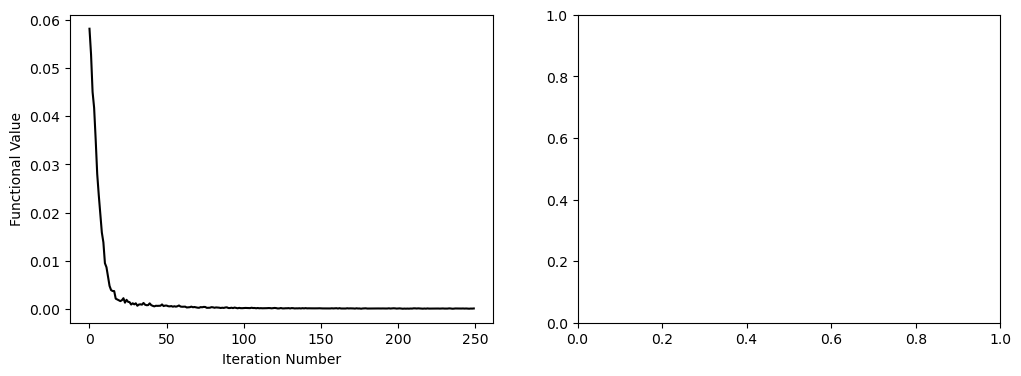

In [48]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))
ax[0].plot(funcs, 'k')
ax[0].set_xlabel("Iteration Number")
ax[0].set_ylabel("Functional Value")

In [49]:
# Testing the model

# Load saved model
model = NeuralNetwork(input_size=8, hidden_size=32, output_size=1)
model.load_state_dict(torch.load('best_model.pth'))


# Evaluate the model
model.eval()
y_preds = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        y_pred = model(batch_x)
        y_preds.append(y_pred.numpy())

# Compute the evaluation metrics

y_pred = np.concatenate(y_preds, axis=0)
y_true = y_test



In [50]:
testing_error_mse = mean_squared_error(y_true, y_pred)
print("MSE: ", testing_error_mse)

MSE:  8.415298e-05


## Questions:

- Do I need all units to be the same?  
No

- Is my MSE good? or is this because my ozone numbers are relatively small?  

- Do I still need to do CNN even tho I am now only 1 person doing the project?  
I will still try to do it because I will learn better abt the architecture and how to build it, but in case I could not figure it out quickly, I still need to find a paper and read it.  






## Predicting Ozone pollution in different cities

In [40]:
# Importing the main meteorological data

pr_temp_wind = pd.read_csv('./Data/pr_temp_wind_2018_2021_NY.csv', sep=',')


In [41]:
pr_temp_wind

,STATION,DATE,AWND,PRCP,TAVG,TMAX,TMIN
0,USW00094728,2018-01-01,3.5,0.0,NaN,-7.1,-13.8
1,USW00094728,2018-01-02,3.6,0.0,NaN,-3.2,-10.5
2,USW00094728,2018-01-03,1.4,0.0,NaN,-1.0,-8.8
3,USW00094728,2018-01-04,5.6,19.3,NaN,-1.6,-7.1
4,USW00094728,2018-01-05,5.8,0.0,NaN,-7.1,-12.7
...,...,...,...,...,...,...,...
1456,USW00094728,2021-12-27,2.0,2.3,NaN,3.9,1.1
1457,USW00094728,2021-12-28,2.1,1.3,NaN,8.3,2.2
1458,USW00094728,2021-12-29,2.6,3.6,NaN,6.7,5.0
1459,USW00094728,2021-12-30,1.1,1.3,NaN,9.4,6.1


https://www.ncei.noaa.gov/access/search/data-search/daily-summaries?bbox=30.883,-98.852,29.529,-96.526&startDate=2018-01-01T00:00:00&endDate=2021-12-31T23:59:59&dataTypes=AWND&dataTypes=PRCP&dataTypes=TAVG&dataTypes=TMAX&dataTypes=TMIN


No Average temperature 